In [1]:
import pandas as pd
import geppy as gep
from deap import creator, base, tools, gp
import numpy as np
import random
import operator
from time import time
import math
import os
from inspect import getmembers, isfunction
from ALLfunctions import singlefunction
import globalVars
import warnings
warnings.filterwarnings("ignore")

In [2]:
#########数据读取#####################
data = pd.read_hdf('./data/T0-1/1325.h5')
data['mid_price'] = (data['ask'] + data['bid'])/2
for i in [1,10,20,100,200,400,600]:
    data[f'mid_price_move_{i}'] = data['mid_price'].pct_change(i).shift(-i)
    print(f'corr with {i} future days:',data[['average_bid_price',f'mid_price_move_{i}']].corr().iloc[0][1])
X = data[['open', 'high', 'low', 'last_price', 'volume', 'turnover',
       'trade_count', 'previous_close', 'high_limit', 'low_limit',
       'total_volume', 'total_value', 'average_ask_price', 'average_bid_price']]
Y = data['mid_price_move_10']

corr with 1 future days: -0.005238679980953211
corr with 10 future days: -0.006580414215309076
corr with 20 future days: -0.00588575807266195
corr with 100 future days: -0.006596367387381373
corr with 200 future days: -0.026166185746248526
corr with 400 future days: -0.052317589989801905
corr with 600 future days: -0.05611432641911119


In [17]:
X_std = X.apply(lambda x: (x - np.mean(x)) / np.std(x))
X_std

,open,high,low,last_price,volume,turnover,trade_count,previous_close,high_limit,low_limit,total_volume,total_value,average_ask_price,average_bid_price
Stock_TW/Z/T0/1325,,,,,,,,,,,,,,
2021-12-27 09:00:03,0.396105,0.395852,0.396340,0.396079,4.074054,3.439819,1.035212,0.359253,0.358665,0.360972,-0.548110,0.501494,0.421725,0.447619
2021-12-27 09:00:06,0.396105,0.395852,0.396340,0.396079,-0.089530,-0.082380,-0.207348,0.359253,0.358665,0.360972,-0.548110,-0.071758,0.420101,0.450810
2021-12-27 09:00:09,0.425621,0.425363,0.425862,0.425595,0.272521,0.225256,2.277771,0.359253,0.358665,0.360972,-0.547442,-0.071758,0.428220,0.458337
2021-12-27 09:00:12,0.433000,0.432741,0.433242,0.432975,0.091495,0.071608,1.035212,0.359253,0.358665,0.360972,-0.547108,-0.071758,0.436543,0.464443
2021-12-27 09:00:15,0.440379,0.440118,0.440623,0.440354,0.272521,0.225935,1.035212,0.359253,0.358665,0.360972,-0.546441,-0.071758,0.442023,0.475840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27 13:29:48,-1.559356,-1.559238,-1.559513,-1.559388,-0.089530,-0.082380,-0.207348,-1.136619,-1.137621,-1.135331,-0.485677,0.121859,-1.555739,-1.193469
2022-05-27 13:29:51,-1.559356,-1.559238,-1.559513,-1.559388,-0.089530,-0.082380,-0.207348,-1.136619,-1.137621,-1.135331,-0.485677,0.121859,-1.555739,-1.193469
2022-05-27 13:29:54,-1.559356,-1.559238,-1.559513,-1.559388,-0.089530,-0.082380,-0.207348,-1.136619,-1.137621,-1.135331,-0.485677,0.121859,-1.555739,-1.193469


In [18]:
X['open'].describe()

count    513000.000000
mean         42.416036
std           6.775904
min          29.400000
25%          38.550000
50%          42.900000
75%          45.900000
max          63.900000
Name: open, dtype: float64

In [16]:
X

,open,high,low,last_price,volume,turnover,trade_count,previous_close,high_limit,low_limit,total_volume,total_value,average_ask_price,average_bid_price
Stock_TW/Z/T0/1325,,,,,,,,,,,,,,
2021-12-27 09:00:03,45.10,45.10,45.10,45.10,23.0,1037.30,1,44.85,49.3,40.4,23.0,1037.30,45.411111,44.987209
2021-12-27 09:00:06,45.10,45.10,45.10,45.10,0.0,0.00,0,44.85,49.3,40.4,23.0,0.00,45.400000,45.013158
2021-12-27 09:00:09,45.30,45.30,45.30,45.30,2.0,90.60,2,44.85,49.3,40.4,25.0,0.00,45.455556,45.074359
2021-12-27 09:00:12,45.35,45.35,45.35,45.35,1.0,45.35,1,44.85,49.3,40.4,26.0,0.00,45.512500,45.124000
2021-12-27 09:00:15,45.40,45.40,45.40,45.40,2.0,90.80,1,44.85,49.3,40.4,28.0,0.00,45.550000,45.216667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27 13:29:48,31.85,31.85,31.85,31.85,0.0,0.00,0,31.30,34.4,28.2,210.0,350.35,31.880657,31.643902
2022-05-27 13:29:51,31.85,31.85,31.85,31.85,0.0,0.00,0,31.30,34.4,28.2,210.0,350.35,31.880657,31.643902
2022-05-27 13:29:54,31.85,31.85,31.85,31.85,0.0,0.00,0,31.30,34.4,28.2,210.0,350.35,31.880657,31.643902


In [3]:
#######生成函数符和终结符#########
def protected_div(x1, x2):
    t = x1 / x2
    return t.replace([np.inf, -np.inf], np.nan)


def sqrt(x):
    return np.sqrt(np.abs(x))


# def s_sqrt(x):
#     if x == 0:
#         return 1
#     else:
#         sign = abs(x)/x
#         return sign* math.sqrt(abs(x))

def s_log(x):
    return np.log(np.abs(x))


pset = gep.PrimitiveSet('Main', input_names=['open', 'high', 'low', 'last_price', 'volume', 'turnover',
                                             'trade_count', 'previous_close', 'high_limit', 'low_limit',
                                             'total_volume', 'total_value', 'average_ask_price', 'average_bid_price'])
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
# pset.add_function(protected_div, 2)
pset.add_function(sqrt, 1)
# pset.add_function(s_sqrt, 1)
pset.add_function(s_log, 1)
pset.add_function(np.abs, 1)

In [4]:
def ts_sum(df, window=10):
    """
    Wrapper function to estimate rolling sum.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """

    return df.rolling(window, min_periods=window//2).sum()


def sma(df, window=10):
    """
    Wrapper function to estimate SMA.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window, min_periods=window//2).mean()


def stddev(df, window=10):
    """
    Wrapper function to estimate rolling standard deviation.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window, min_periods=window//2).std()

pset.add_function(ts_sum, 1)
pset.add_function(sma, 1)
pset.add_function(stddev, 1)

In [5]:
#####创建目标函数和个体样本类##########
# creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
# creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

creator.create("FitnessMax", base.Fitness, weights=(1,))  # to maximize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMax)

h = 7 # head length
n_genes = 2   # number of genes in a chromosome
toolbox = gep.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

In [23]:
# def evaluate(individual):
#     """Evalute the fitness of an individual: MAE (mean absolute error)"""
#     func = toolbox.compile(individual)
# #     Yp = list(map(func, X['high'],X['low'],X['open'],X['last_price'],X['volume'],X['turnover'],X['trade_count'],X['previous_close'],
# #                  X['high_limit'],X['low_limit'],X['total_volume'],X['total_value'],X['average_ask_price'],X['average_bid_price']))
#     Yp = list(func(X['high'],X['low'],X['open'],X['last_price'],X['volume'],X['turnover'],X['trade_count'],X['previous_close'],
#              X['high_limit'],X['low_limit'],X['total_volume'],X['total_value'],X['average_ask_price'],X['average_bid_price']))
#     #ic = pd.DataFrame(Y.values)[0].corr(pd.DataFrame(Yp)[0])
#     ic_mat = pd.DataFrame(Yp)
#     ic_mat['Y'] = Y.values
#     ic_mat.columns = ['Yp', 'Y']
#     ic = ic_mat[['Yp','Y']].corr().iloc[0][1]
#     #ic = pd.DataFrame(Y.values)[0]
#     return abs(ic),

def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
#     Yp = list(map(func, X['high'],X['low'],X['open'],X['last_price'],X['volume'],X['turnover'],X['trade_count'],X['previous_close'],
#                  X['high_limit'],X['low_limit'],X['total_volume'],X['total_value'],X['average_ask_price'],X['average_bid_price']))
    Yp = list(func(X_std['high'],X_std['low'],X_std['open'],X_std['last_price'],X_std['volume'],X_std['turnover'],
                   X_std['trade_count'],X_std['previous_close'],X_std['high_limit'],X_std['low_limit'],X_std['total_volume'],
                   X_std['total_value'],X_std['average_ask_price'],X_std['average_bid_price']))
    #ic = pd.DataFrame(Y.values)[0].corr(pd.DataFrame(Yp)[0])
    ic_mat = pd.DataFrame(Yp)
    ic_mat['Y'] = Y.values
    ic_mat.columns = ['Yp', 'Y']
    ic = ic_mat[['Yp','Y']].corr().iloc[0][1]
    #ic = pd.DataFrame(Y.values)[0]
    return abs(ic),

toolbox.register('evaluate', evaluate)

In [7]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.4)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
toolbox.register('mut_ephemeral', gep.mutate_uniform_ephemeral, ind_pb='1p')  # 1p: expected one point mutation in an individual
toolbox.pbs['mut_ephemeral'] = 1 

In [8]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# 标准化因子后的迭代算法

In [24]:
#######针对标准化因子后的#########
#######开始进行遗传算法迭代#############
# size of population and number of generations
n_pop = 100
n_gen = 40

pop_std = toolbox.population(n=n_pop)
hof_std = tools.HallOfFame(10)   # only record the best three individuals ever found in all generations
# start evolution

pop_std, log_std = gep.gep_simple(pop_std, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof_std, verbose=True)

gen	nevals	avg      	std      	min       	max     
0  	100   	0.0215384	0.0238088	0.00189112	0.163295
1  	99    	0.0396607	0.0390784	0.00240078	0.163295
2  	99    	0.061196 	0.0496951	0.00126521	0.164575
3  	99    	0.0906703	0.0552301	0.00044689	0.193753
4  	99    	0.110168 	0.057209 	0.00131134	0.193753
5  	99    	0.11021  	0.0644983	0.000318248	0.193753
6  	99    	0.122966 	0.0636401	0.000122176	0.193786
7  	99    	0.129097 	0.0603406	0.000793965	0.194558
8  	99    	0.133082 	0.0627582	0.000780341	0.197364
9  	99    	0.129698 	0.0705214	8.00419e-05	0.197364
10 	99    	0.138051 	0.0656801	0.000836511	0.197364
11 	99    	0.138802 	0.0671161	0.00102647 	0.197364
12 	99    	0.14044  	0.0671595	6.11479e-05	0.197364
13 	99    	0.149757 	0.0599863	7.87964e-05	0.197364
14 	99    	0.149815 	0.0646701	0.000246057	0.197364
15 	99    	0.118858 	0.0746276	0.000170171	0.197364
16 	99    	0.135469 	0.067109 	0.00396415 	0.197364
17 	99    	0.140631 	0.067119 	0.000199879	0.19739 
18 	99    	0.13326

In [27]:
stdbest0 = hof_std[0]
print(stdbest0.fitness)
stdbest0

(0.37822405786313046,)


<class 'deap.creator.Individual'>[
	<class 'geppy.core.entity.Gene'> [s_log, mul, volume, stddev, sma, sub, ts_sum, low_limit, previous_close, open, open, average_bid_price, open, high_limit, turnover],
	<class 'geppy.core.entity.Gene'> [mul, total_value, mul, ts_sum, sub, sma, low, average_ask_price, total_value, average_ask_price, previous_close, total_value, average_ask_price, turnover, volume]
], linker=<built-in function add>

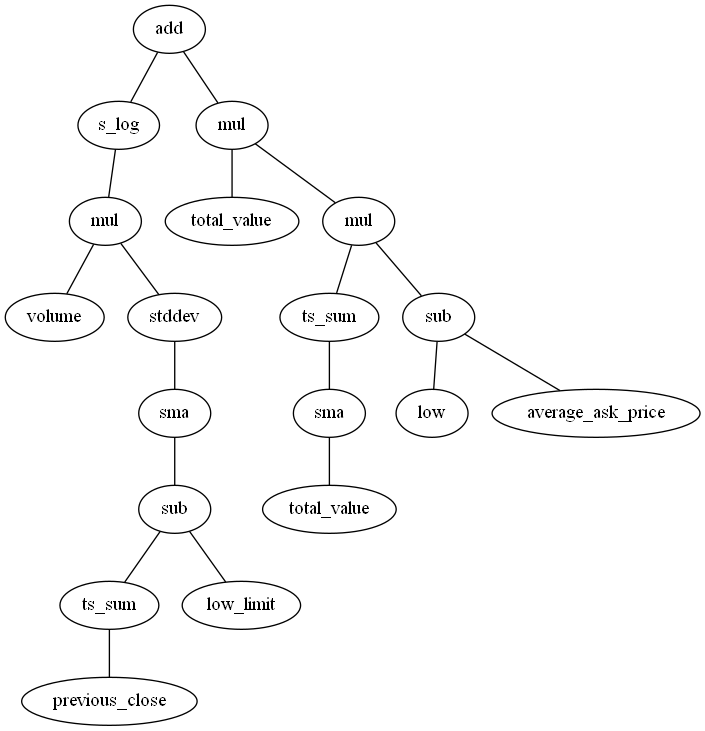

In [38]:
rename_labels = {'and_': '&', 'or_': '|', 'not_': '~'}   # we want use symbol labels instead of words in the tree graph
gep.export_expression_tree(stdbest0, rename_labels, 'data/bool_tree.png')
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/bool_tree.png')

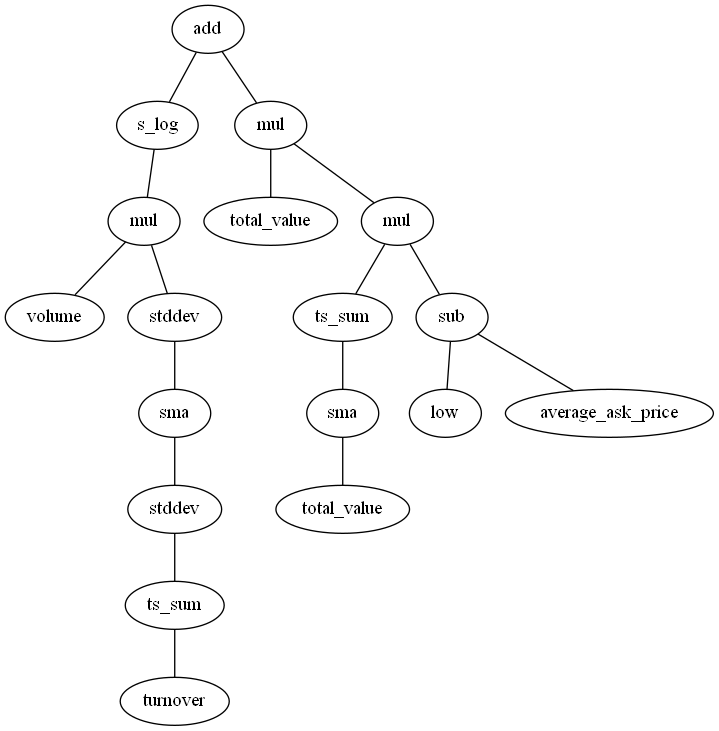

In [39]:
rename_labels = {'and_': '&', 'or_': '|', 'not_': '~'}   # we want use symbol labels instead of words in the tree graph
gep.export_expression_tree(stdbest1, rename_labels, 'data/bool_tree.png')
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/bool_tree.png')

In [29]:
stdbest1 = hof_std[1]
print(stdbest1.fitness)
stdbest1

(0.22252221910378545,)


<class 'deap.creator.Individual'>[
	<class 'geppy.core.entity.Gene'> [s_log, mul, volume, stddev, sma, stddev, ts_sum, turnover, previous_close, open, average_ask_price, low_limit, trade_count, trade_count, total_value],
	<class 'geppy.core.entity.Gene'> [mul, total_value, mul, ts_sum, sub, sma, low, average_ask_price, total_value, turnover, total_volume, low_limit, trade_count, turnover, volume]
], linker=<built-in function add>

In [37]:
print(stdbest0)

add(
	s_log(mul(volume, stddev(sma(sub(ts_sum(previous_close), low_limit))))),
	mul(total_value, mul(ts_sum(sma(total_value)), sub(low, average_ask_price)))
)


In [31]:
func0 = toolbox.compile(stdbest0)
Yp = list(func0(X_std['high'],X_std['low'],X_std['open'],X_std['last_price'],X_std['volume'],X_std['turnover'],
               X_std['trade_count'],X_std['previous_close'],X_std['high_limit'],X_std['low_limit'],X_std['total_volume'],
               X_std['total_value'],X_std['average_ask_price'],X_std['average_bid_price']))
#ic = pd.DataFrame(Y.values)[0].corr(pd.DataFrame(Yp)[0])
ic_mat = pd.DataFrame(Yp)
ic_mat['Y'] = Y.values
ic_mat.columns = ['Yp', 'Y']
ic_mat[['Yp','Y']].corr().iloc[0][1]

0.37822405786313046

In [33]:
Yp

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -2.590177314876562,
 -4.769817187008093,
 -2.735352860700874,
 -3.620412287461591,
 -3.172773929759791,
 -4.750349173538701,
 -4.58136913762252,
 -2.314736855883197,
 -2.3613737258726237,
 -3.7638075602819923,
 -1.3979088453244155,
 -1.0979872606148071,
 -2.3778723067635923,
 -1.3466878372947875,
 -3.6762942024346037,
 -3.828298156563659,
 -2.9692641949917498,
 -4.375419209678821,
 -2.4292583795407325,
 -5.460035804743694,
 -6.390122511544444,
 -5.009771033707615,
 -7.0095032273341555,
 -6.760948783908986,
 -3.751026356807624,
 -4.081158965596807,
 -3.7566079192913135,
 -5.142333721333397,
 -4.954773142874793,
 -4.879531900330242,
 -4.841566727219642,
 -4.877632508105245,
 -4.9876521780074965,
 -3.2147238880240416,
 -5.419211061514723,
 -5.697051921941444,
 -6.076936313455795,
 -3.8445554094269037,
 -6.512891573914829,
 -6.432648638997463,
 -6.308560812133864,
 -5.205575313072311,
 -6.41130

In [34]:
Y

Stock_TW/Z/T0/1325
2021-12-27 09:00:03    0.008850
2021-12-27 09:00:06    0.008292
2021-12-27 09:00:09    0.007178
2021-12-27 09:00:12    0.006067
2021-12-27 09:00:15    0.006057
                         ...   
2022-05-27 13:29:48         NaN
2022-05-27 13:29:51         NaN
2022-05-27 13:29:54         NaN
2022-05-27 13:29:57         NaN
2022-05-27 13:30:00         NaN
Name: mid_price_move_10, Length: 513000, dtype: float64

In [35]:
func01 = toolbox.compile(stdbest1)
Yp = list(func01(X_std['high'],X_std['low'],X_std['open'],X_std['last_price'],X_std['volume'],X_std['turnover'],
               X_std['trade_count'],X_std['previous_close'],X_std['high_limit'],X_std['low_limit'],X_std['total_volume'],
               X_std['total_value'],X_std['average_ask_price'],X_std['average_bid_price']))
#ic = pd.DataFrame(Y.values)[0].corr(pd.DataFrame(Yp)[0])
ic_mat = pd.DataFrame(Yp)
ic_mat['Y'] = Y.values
ic_mat.columns = ['Yp', 'Y']
ic_mat[['Yp','Y']].corr().iloc[0][1]

0.22252221910378545

In [36]:
Yp

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -2.590177314876562,
 -4.769817187008093,
 -2.735352860700874,
 -3.620412287461591,
 -3.172773929759791,
 -4.750349173538701,
 -4.58136913762252,
 -2.314736855883197,
 -2.3613737258726237,
 -3.7638075602819923,
 -1.3979088453244155,
 -1.0979872606148071,
 -2.3778723067635923,
 -1.3466878372947875,
 -3.6762942024346037,
 -3.828298156563659,
 -2.9692641949917498,
 -4.375419209678821,
 -2.4292583795407325,
 -5.460035804743694,
 -6.390122511544444,
 -5.009771033707615,
 -7.0095032273341555,
 -6.760948783908986,
 -3.751026356807624,
 -4.081158965596807,
 -3.7566079192913135,
 -5.142333721333397,
 -4.954773142874793,
 -4.879531900330242,
 -4.841566727219642,
 -4.877632508105245,
 -4.9876521780074965,
 -3.2147238880240416,
 -5.419211061514723,
 -5.697051921941444,
 -6.076936313455795,
 -3.8445554094269037,
 -6.512891573914829,
 -6.432648638997463,
 -6.308560812133864,
 -5.205575313072311,
 -6.41130

In [9]:
#######开始进行遗传算法迭代#############
# size of population and number of generations
n_pop = 100
n_gen = 40

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(10)   # only record the best three individuals ever found in all generations
# start evolution

pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg      	std      	min        	max     
0  	100   	0.0273051	0.0283179	0.000688117	0.089793
1  	99    	0.0441758	0.0351003	0.00354593 	0.146304
2  	99    	0.0640052	0.0356121	0.00116079 	0.146304
3  	99    	nan      	nan      	nan        	nan     
4  	99    	nan      	nan      	nan        	nan     
5  	99    	nan      	nan      	nan        	nan     
6  	99    	0.0882996	0.0458042	0.00131574 	0.152279
7  	99    	0.0952665	0.0520357	0.000897542	0.167752
8  	99    	0.102571 	0.0502003	0.00117732 	0.167752
9  	99    	0.0986189	0.0590256	0.00123811 	0.201458
10 	99    	0.11199  	0.0506193	0.000220859	0.201458
11 	99    	0.110285 	0.0531757	0.00267519 	0.201458
12 	99    	0.114865 	0.0555659	0.00388903 	0.205714
13 	99    	0.114285 	0.0557623	0.00190934 	0.221746
14 	99    	0.114766 	0.0587581	0.00205721 	0.221746
15 	99    	0.120948 	0.0660223	0.00203145 	0.221754
16 	99    	0.109892 	0.067756 	0.000510233	0.221754
17 	99    	0.13231  	0.0580845	0.00313303 	0.221754
18 	99    	0

In [12]:
best1 = hof[1]
best1.fitness

deap.creator.FitnessMax((0.24436392632215537,))

In [19]:
func1 = toolbox.compile(best1)
Yp = list(func1(X['high'],X['low'],X['open'],X['last_price'],X['volume'],X['turnover'],X['trade_count'],X['previous_close'],
         X['high_limit'],X['low_limit'],X['total_volume'],X['total_value'],X['average_ask_price'],X['average_bid_price']))
#ic = pd.DataFrame(Y.values)[0].corr(pd.DataFrame(Yp)[0])
ic_mat = pd.DataFrame(Yp)
ic_mat['Y'] = Y.values
ic_mat.columns = ['Yp', 'Y']
ic = ic_mat[['Yp','Y']].corr().iloc[0][1]

In [20]:
Yp

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 7515.32633271698,
 7563.378353342734,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 4047.0263737504065,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [22]:
ic_mat[['Yp','Y']].corr().iloc[0][1]

-0.24436392632215537

In [13]:
best2 = hof[2]
best2.fitness

deap.creator.FitnessMax((0.2443637332089216,))

In [14]:
rename_labels = {'and_': '&', 'or_': '|', 'not_': '~'}   # we want use symbol labels instead of words in the tree graph
gep.export_expression_tree(best1, rename_labels, 'data/bool_tree.png')
# show the above image here for convenience

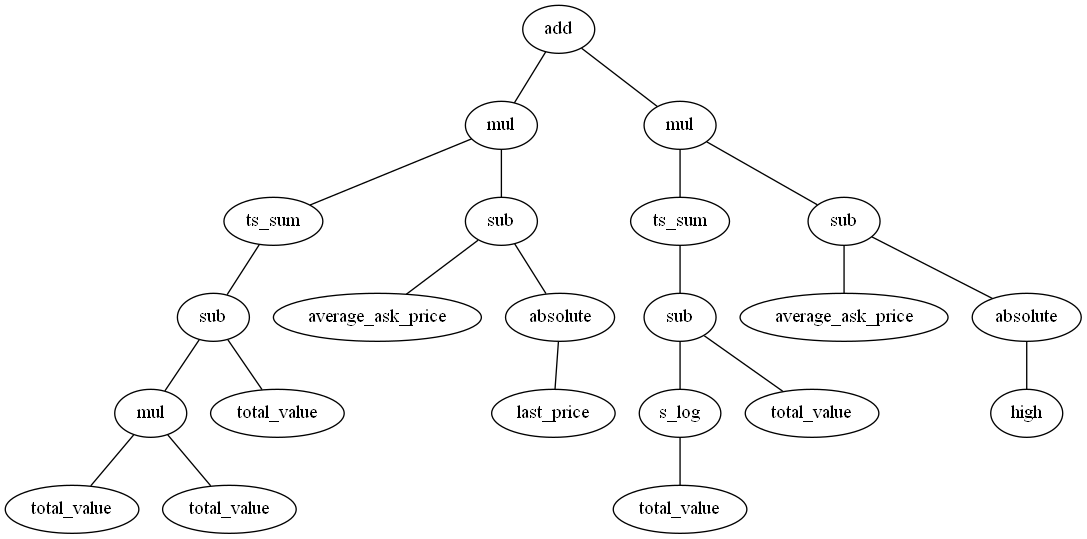

In [15]:
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/bool_tree.png')